In this notebook i will illustrate how to obtain some mesoscopic features using the library. I will focus on two of main concepts:

<ol>
<li>Accessibility -> Gravity model & cumulative</li>
<li>Accessibility -> Walk score (requires API Key)</li>
</ol>

A visualization that i would like to illustrate as part of this is how street attributes vary as you follow a path through the network. 

Just as a conceptual recap the <b>Gravity-based accessibility</b> for a point $p$ can be defined in the following manner:

$$A(p) = \sum_{j} \frac{O(a_{j})}{e^{d(p, a_{j})}}$$

where $O(a_{j})$ is the weight or importance of amenity $a_{j}$, and $d(p, a_{j})$ is a measure of how "far" is the pont from $a_{j}$ you should think of $d$ not as a distance necessarily but as a metric in general, it could also be time, or a distance refined based on perceptions. 

The <b>cumulative accessibility</b> is defined in the following way:

$$A(p) = \sum_{j} O(a_j) \cdot \mathbb{1}\left( d(p, a_j) \leq \tau \right)$$

It tells you how many important amenities you can reach within a distance. 

Walk-score is a black box, you need to request an API key to use it, but i provide a function to calculate the walk score for a set of given points. and projecting the results to the street network. 

### 1.Gravity-based accessibility

In [17]:
from alivestreets.features.mesoscopic import compute_gravity_accessibilities
from alivestreets.sampling.street_sampler import StreetSampler
import os
import geopandas as gpd

#Let's open the street network. This network's geojson was obtained as 
# part of the sampling_test notebook.
path_network = os.path.join(os.getcwd(), "data", "network.geojson")
sampler = StreetSampler(200)
sampler.open_streets(path_network)
print(f"Opened network, the number of streets is {len(sampler.streets)}")

#We will examine accessibility from sampled points in the network to amenities, 
# for instance bus stops.
sampler.sample_streets_no_intersections()
sampling_points = sampler.get_all_sampling_points()

#Open the parks geojson, we learned how to obtain these files in the sampling_test
# notebook.
path_bus_stops = os.path.join(os.getcwd(), "data", "features", "bus_stops.geojson")
bus_gdf = gpd.read_file(path_bus_stops)
busses = list(bus_gdf["geometry"])
busses = [[p.x, p.y] for p in busses]



Opened network, the number of streets is 268


In [18]:
#Once everything is loaded you can calculate the gravity-based accessibility for all the sampling
#points. This can take a while to run (about 1 minute for this example). 
from alivestreets.network.graph_utilities import build_graph_from_sampler
from alivestreets.features.mesoscopic import compute_gravity_accessibilities

graph = build_graph_from_sampler(sampler)
weights  = [1.0]*len(sampling_points)
gravity_based_access = compute_gravity_accessibilities(
    sampling_points,
    busses, 
    weights,
    graph, 
    distance_type = "network", 
    beta = 0.001
)
#Now we can tag the streets with the gravity-based accessibility values.
#We will assign each street the mean value of the accessibilities for individual points.
sampler.tag_streets(
    "gravity_based_access", 
    gravity_based_access, 
    method = "mean"
)


  1%|          | 4/355 [00:00<00:49,  7.03it/s]/Users/juanlegaria/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/CFC/alivestreets/alivestreets/.venv/lib/python3.11/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/Users/juanlegaria/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/CFC/alivestreets/alivestreets/.venv/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
100%|██████████| 355/355 [00:49<00:00,  7.21it/s]


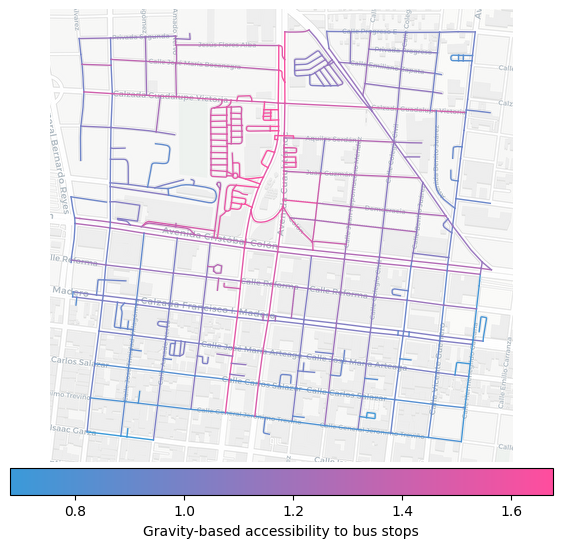

In [19]:
#visualize the gravity-based accessibility of each of the streets. 
from alivestreets.visualization.map_visualizer import MapVisualizer

vis = MapVisualizer()
vis.initialize_map(figsize = (7,7))
vis.add_street_sampler(sampler, 
"gravity_based_access", 
variable_type="continuous",
edge_width = 1)

vis.draw_networks(colorbar_label = "Gravity-based accessibility to bus stops", colorbar_orientation = "horizontal")

vis.add_basemap(alpha = 0.9)
vis.finalize_map()

### 2. Cumulative accessibility

In [20]:
from alivestreets.features.mesoscopic import compute_cumulative_accessibilities
#Now we can also compute the cumulative accessibility, which is a measure of how many amenities
# can be reached within a certain distance threshold. The threshold is set to 400 meters in this example.
cumulative_access =  compute_cumulative_accessibilities(
    sampling_points,
    busses, 
    weights,
    graph, 
    distance_type = "network", 
    threshold = 400
)

sampler.tag_streets(
    "cumulative_access", 
    cumulative_access, 
    method = "mean"
)


100%|██████████| 355/355 [00:49<00:00,  7.17it/s]


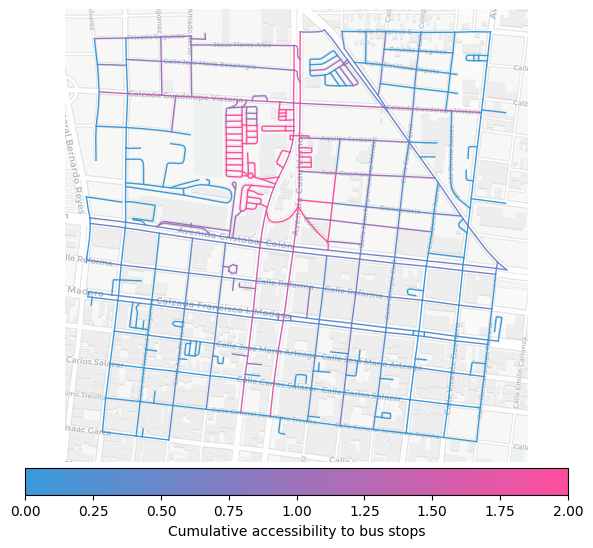

In [21]:


vis = MapVisualizer()
vis.initialize_map(figsize = (7,7))
vis.add_street_sampler(sampler, 
"cumulative_access", 
variable_type="continuous",
edge_width = 1)

vis.draw_networks(colorbar_label = "Cumulative accessibility to bus stops", colorbar_orientation = "horizontal")

vis.add_basemap(alpha = 0.9)
vis.finalize_map()


### 3. Feature changes over trajectory

In [22]:
#Now let's visualize how the gravity-based accessibility changes along a trajectory.
from alivestreets.network.graph_utilities import attach_sampler_segment_attributes_to_graph

attach_sampler_segment_attributes_to_graph(graph, 
sampler, 
"gravity_based_access", 
aggregation = "mean")

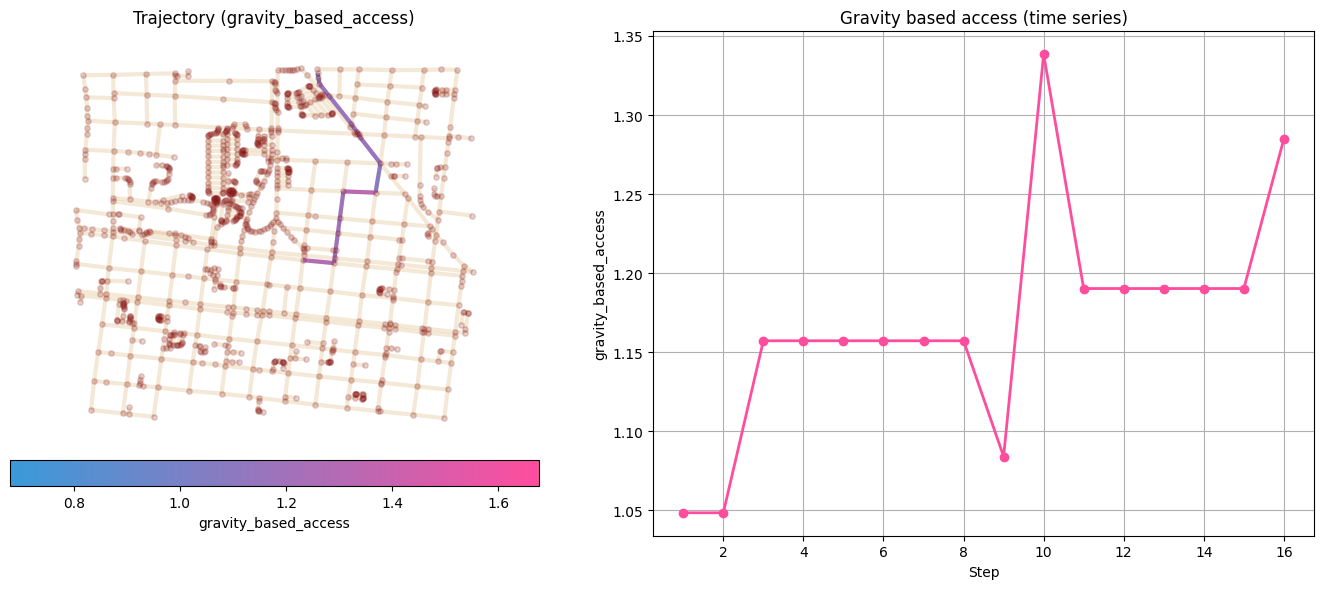

In [23]:
from alivestreets.visualization.trajectory_visualizer import plot_trajectory_on_graph, plot_attribute_time_series
import networkx as nx
import matplotlib.pyplot as plt

initial_node = 10
final_node = 1
undirected_graph = graph.to_undirected()

trajectory = nx.shortest_path(undirected_graph, source=initial_node, target=final_node, weight="length")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the trajectory on the graph
plot_trajectory_on_graph(
    G=undirected_graph,
    trajectory=trajectory,
    attribute_name="gravity_based_access",
    edge_size = 3.0,
    width = 3.0, 
    node_size = 15,
    ax=ax1, 
    alpha = 0.2, 
    node_color = "#8B1A1A"
)

# Plot the time series
plot_attribute_time_series(
    trajectory=trajectory,
    G=undirected_graph,
    attribute_name="gravity_based_access",
    ax=ax2, 
    title = "Gravity based access (time series)"
)

plt.tight_layout()
plt.show()

### 4. Walk score

Finally, let's get the walk-score. For obtaining such metric one needs an API key, which can be requested from 

<p>https://www.walkscore.com/methodology.shtml</p>

While the metric is a black box, it is supposed to examine accessibility to amenities in different categories. Scores range from 0 to 100, and the "interpretation" of the measures' intervals is the following:

<ul>
<li>90 - 100 (Walker's paradise)</li>
<li>70 - 89 (Very walkable)</li>
<li>50 - 69 (Somewhat walkable)</li>
<li>25 - 49 (Car dependent)</li>
<li>0 - 24 (Car dependent)</li>
</ul>


I think the last category should have been called walker's nightmare or monster truck arena for the convention to be consistent. It is like quarks, if you name one strange you might as well call the other one charm. 

In [13]:
from alivestreets.features.mesoscopic import get_walk_scores

api_key = ""
walk_scores = get_walk_scores(api_key,sampling_points)


100%|██████████| 355/355 [01:28<00:00,  4.01it/s]


In [24]:
#Since walk-score retrieval is limited we should save the values.
import pandas as pd
df = pd.DataFrame(sampling_points, columns = ["longitude", "latitude"])
df["walk score"] = walk_scores

save_path = os.path.join(os.getcwd(), "data", "walk_scores.csv")
df.to_csv("walk_scores.csv", index=False)


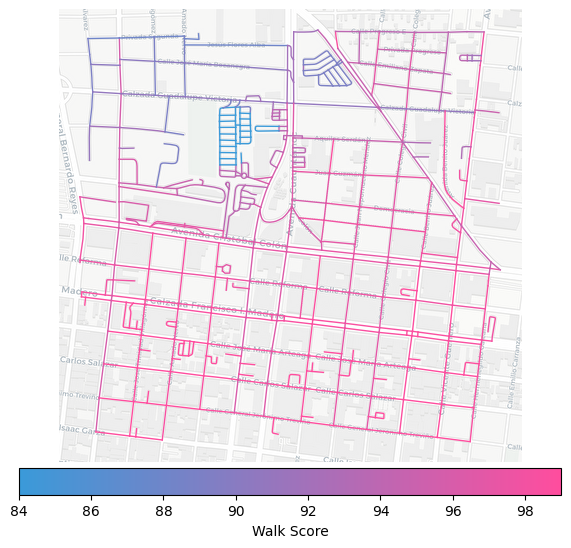

In [16]:
#Visualize the metric
sampler.tag_streets(
    "walk_score", 
    walk_scores, 
    method = "mean"
)

vis = MapVisualizer()
vis.initialize_map(figsize = (7,7))
vis.add_street_sampler(sampler, 
"walk_score", 
variable_type="continuous",
edge_width = 1)

vis.draw_networks(colorbar_label = "Walk Score", colorbar_orientation = "horizontal")

vis.add_basemap(alpha = 0.9)
vis.finalize_map()


As can be observed Walk Score seems different than accessibility to bus stops. This is understandable since other amenity types are being considered in its calculation. Still, it tends to overlook important microscopic details like the condition of the sidewalks or other aspects that might affect walkability. Which leads us to the use of Machine Learning models for detecting microscopic features such as vegetation, sky view, façade characteristics, among others. 